## Amazon Reviews Sentiment Classification
_______________________________________________________________________________________________________________________________
In this project, I classify Amazon reviews' sentiments using Natual Language Processing (NLP) Models. I first use a simple Naive Bayes classification method which is a probabilistic model. Then I use a Neural Network based architecture. Finally, I use two single-layered bidirectional RNN models - one of which has Gated Recurrent Units (GRU) and the other has Long-Short Term Memory (LSTM) units. In the last three models I use word embeddings in the very first layer of the neural architecture. I use both pre-trained word embeddings and also word embeddings which I generate as part of the training process.  


### Executive Summary

#### (A) Project Goal
Classify Amazon reviews sentiment using probabilistic and sequence models of NLP.

#### (B) Natural Language Processing Classification Models
I use the following classification models:

1. **Probabilistic Model:**
    * Naive Bayes 
2. **Sequence Models:**
    * Neural Network With Word Embeddings
    * Single-Layer Bi-directional Recurrent Neural Network (RNN) with **Gated Recurrent Units (GRU)** and Word Embeddings
    * Single-Layer Bi-directional Recurrent Neural Network (RNN) with **Long-Short Term Memory (LSTM)** units and Word Embeddings
    
For each of the sequence models above, I implement two types of models - one in which the first layer word embeddings are learned as part of the training processm, and a second in which I use **GloVe** word embeddings. 

I then evaluate each model by computing accuracy, precision, recall, f1 score, and roc-auc score on the test predictions. Then I plot all these metrics for each of the classification models.

#### (C) Model Comparison Preview

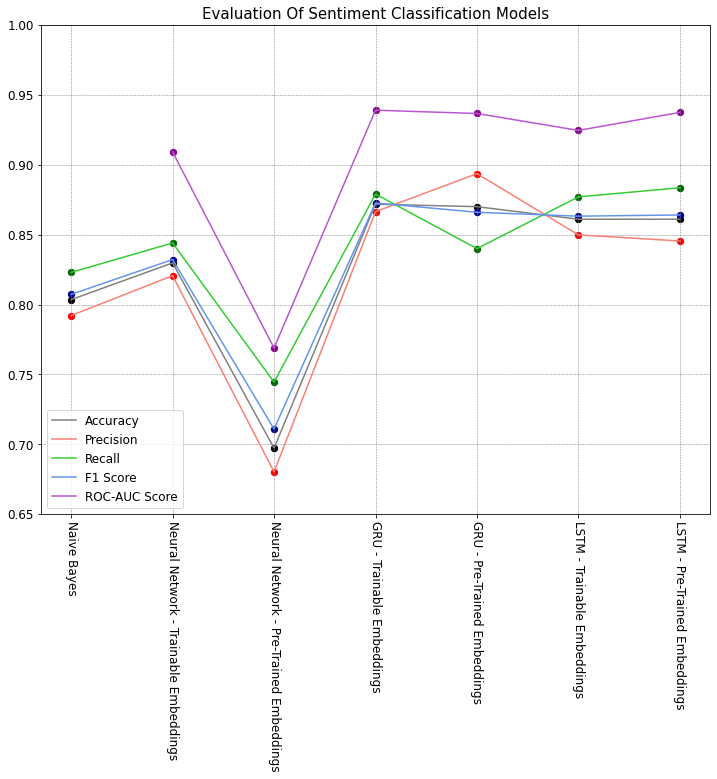

#### (D) Conclusion

The best model on the basis of accuracy metric seems to be a single-layered RNN with GRU units and trainable word embeddings. 

Evaluation metrics:
* Accuracy = 0.872
* Precision = 0.866
* Recall = 0.879
* F1 Score = 0.873
* ROC-AUC Score = 0.939


In [ ]:
# Importing libraries

!pip install keras

import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
nltk.download('twitter_samples')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
nltk.download('punkt') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random
import os
from os import getcwd
import seaborn as sns 
import string
import re
import pdb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
#import gensim
#from gensim.models import KeyedVectors 
import scipy
import collections
from collections import Counter
#import emoji
import random
import pprint
import IPython 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import json
import csv
import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)
import bz2
import time
import multiprocessing as mp 
mp.cpu_count()
from concurrent import futures
import pickle
import torch
from torch.multiprocessing import Pool

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.6.0
1.19.5


In [ ]:
# Defining filenames
inputtrain = "train.ft.txt.bz2"
inputtest = "test.ft.txt.bz2"
outputtrain = "train"
outputtest = "test"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining data holder for input 
intrain = []
intest = []

# Loading training and test data 
with bz2.open(os.path.join("drive/MyDrive", inputtrain), 'rt', encoding='utf-8') as f:
    for line in f:
        l = line.strip()
        intrain.append(l)
with bz2.open(os.path.join("drive/MyDrive", inputtest), 'rt', encoding='utf-8') as f:
    for line in f:
        l = line.strip()
        intest.append(l)        

In [ ]:
# Importing pre-trained GloVe word embeddings 

embeddings_index = {}
with open(os.path.join("drive/MyDrive", 'glove.6B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

In [ ]:
# Checking the number of input training and test examples
numtrain = len(intrain)
numtest = len(intest)

print(f"Number of training examples: {numtrain}")
print(f"Number of test examples: {numtest}")

Number of training examples: 3600000
Number of test examples: 400000


Next, we separate each training and test example, into sentence and labels. Each example has the following string at the very beginning of the example: \_\_label\_\_i, where `i' denotes the number of review stars for that example. After the label, the example contains the title of the review which ends with ':'. So we extract, the title, the label, and the actual review text for each example in both training and test sets. 

In [ ]:
train_X = []
train_X_title = []
train_Y = []
test_X = []
test_X_title = []
test_Y = []

for i in np.arange(numtrain):
    train_X.append(re.findall('(?<=: ).*$', intrain[i])[0])
    firststr = re.sub('\:.*','',intrain[i])
    train_X_title.append(re.findall('(?<=__label__[0-9] ).*$', firststr)[0])
    train_Y.append(int(re.findall('[0-9]' ,str(re.findall(r'__label__[0-9]+ ', firststr)[0]))[0]))
for i in np.arange(numtest):
    test_X.append(re.findall('(?<=: ).*$', intest[i])[0])
    firststr = re.sub('\:.*','',intest[i])
    test_X_title.append(re.findall('(?<=__label__[0-9] ).*$', firststr)[0])
    test_Y.append(int(re.findall('[0-9]' ,str(re.findall(r'__label__[0-9]+ ', firststr)[0]))[0]))

In [ ]:
# Instead of working with the huge data, we work with 1% of the training set (1% of each of the two labels)
# and similarly we work with 1% of the test set (1% of each of the two labels)

train_ratio = 0.01
test_ratio = 0.01
random.seed(891)

train_X_1 = [review for counter, review in enumerate(train_X) if train_Y[counter] == 1]
train_X_2 = [review for counter, review in enumerate(train_X) if train_Y[counter] == 2]
test_X_1 = [review for counter, review in enumerate(test_X) if test_Y[counter] == 1]
test_X_2 = [review for counter, review in enumerate(test_X) if test_Y[counter] == 2]

subtrain_X_1 = random.choices(train_X_1, k=int(len(train_X_1)*train_ratio))
subtrain_X_2 = random.choices(train_X_2, k=int(len(train_X_2)*train_ratio))
subtest_X_1 = random.choices(test_X_1, k=int(len(test_X_1)*test_ratio))
subtest_X_2 = random.choices(test_X_2, k=int(len(test_X_2)*test_ratio))

subtrain_X = subtrain_X_1+subtrain_X_2
subtest_X = subtest_X_1+subtest_X_2

subtrain_Y = [1 for i in np.arange(len(subtrain_X_1))]+[2 for i in np.arange(len(subtrain_X_2))]
subtest_Y = [1 for i in np.arange(len(subtest_X_1))]+[2 for i in np.arange(len(subtest_X_2))]

In [ ]:
# Some Training Examples

for i in np.arange(3):
    print(f"Example {i+1}:\n Review: {subtrain_X[i]}\n Review Label: {subtrain_Y[i]}\n")
    
print(f"Number of training examples and labels extracted: {len(subtrain_X), len(subtrain_Y)}")
print(f"Number of test examples and labels extracted: {len(subtest_X), len(subtest_Y)}")
print(f"Unique labels in training set: {set(subtrain_Y)}")
print(f"Unique labels in test set: {set(subtest_Y)}")

Example 1:
 Review: I don't understand what readers see in any of Cozzens' books. Who in the world would think these things are well written? Just because his research is detailed (thus the two stars) doesn't make the book good. His dry-as-dust descriptions of unit movements read like a laundary list. A reviewer wrote of another of his books "Cozzens does it again". Well, that review will itself keep me from reading that book. Unfortunately, so little has been written about Stones River that anyone interested in the war in Tennessee can not avoid this thing.
 Review Label: 1

Example 2:
 Review: It only lasts one winter. The warranty doesn't help much. I am going to ship it back, but it cost another 20 dallar shipping fee. I don't know what to do if it breaks again...
 Review Label: 1

Example 3:
 Review: It is better to have this book than nothing. It does have some basic information in it. But there are also very basic things left out. Things like practical information to help with p

Label "1" denotes 1 and 2 stars and label "2" denotes 4 and 5 stars. 3 stars (which might represent neutral reviews) have been removed from the training and test examples. 

### Model 1: Naive Bayes Method for Sentiment Classification

First, we preprocess each review by performing the following operations on each tweet:
* Tokenizing (Convert a review to a list of words)
* Lowercasing (Change all characters to lowercase)
* Removing all stopwords and punctuations 
* Stemming (Convert all words into root words)

In [ ]:
# Define a function which preprocesses each review
def preprocess_review(review):
    
    # Remove hyperlinks
    review = re.sub(r'https?:\/\/.*[\r\n]*', '', review)
    # Remove hashtags 
    review = re.sub(r'#', '', review)  
    
    # Tokenize review and change to lowercase  
    review_tokens = nltk.word_tokenize(review.lower())
    
    # Now remove stopwords and punctuations
    review_clean = []
    for token in review_tokens:
        if(token not in stopwords.words('spanish') and 
           token not in stopwords.words('english') and 
           token not in string.punctuation):
            review_clean.append(token)
            
    # Now stem words to get only root words
    stemmer = PorterStemmer()
    review_stemmed = []
    for token in review_clean:
        review_stemmed.append(stemmer.stem(token))
        
    return review_stemmed

In [ ]:
processed_train = []
processed_test = []

starttime = time.time()

# for i in np.arange(len(subtest_X)):
#     processed_test.append(preprocess_review(subtest_X[i]))
# for i in np.arange(len(subtrain_X)):
#     processed_train.append(preprocess_review(subtrain_X[i]))

pool = Pool()
processed_test = pool.map(preprocess_review, [review for review in subtest_X])
pool.close()

pool = Pool()
processed_train = pool.map(preprocess_review, [review for review in subtrain_X])
pool.close()

# with futures.ProcessPoolExecutor(max_workers=mp.cpu_count()) as pool:
#     res = pool.map(preprocess_review, subtest_X_1, chunksize=mp.cpu_count())

print(time.time()-starttime)

850.9881088733673


In [ ]:
with open(os.path.join("drive/MyDrive",'processed_train.txt'), 'wb') as f:
    pickle.dump(processed_train, f)
with open(os.path.join("drive/MyDrive",'processed_test.txt'), 'wb') as f:
    pickle.dump(processed_test, f)

Next, we define a function which creates a dictionary. Each dictionary key is a (word, label) tuple and the key value is the number of times the word appears in the set of reviews with that label. We build this dictionary using only the training set. 

In [ ]:
# Define a function to create word frequency 

def gen_wordfreq(xlist, ylist):

  # Initialize an empty dictionary 
  wordfreq = {}
  # Now iterate over each word in each review
  for counter, review in enumerate(xlist):
    for word in review:
        wordfreq[(word, ylist[counter])] = wordfreq.get((word, ylist[counter]), 0) + 1
  # Return the dictionary
  return wordfreq


In [ ]:
# Now create the (word, label) frequency dictionary with only the training data. 

print(f"Length of processed training sets of reviews and labels: {len(processed_train), len(subtrain_Y)}")
wordfreq = gen_wordfreq(processed_train, subtrain_Y)
print(f"Size of generated dictionary: {len(wordfreq)}")
print(f"Unique labels in frequency dictionary: {set([label for _,label in wordfreq.keys()])}")

Length of processed training sets of reviews and labels: (36000, 36000)
Size of generated dictionary: 90408
Unique labels in frequency dictionary: {1, 2}


In [ ]:
# Now generate a vocabulary and a size of the vocabulary 
vocab = set([key for key,_ in wordfreq.keys()])
V = len(vocab)

# Number of reviews with labels 1 and 2 
D1 = len(subtrain_X_1)
D2 = len(subtrain_X_2)

# Frequency of all words with label 1 
N1 = sum([wordfreq[(word,1)] for word in vocab if (word,1) in wordfreq])
N2 = sum([wordfreq[(word,2)] for word in vocab if (word,2) in wordfreq])

print(f"Length of training vocabulary: {V}")
print(f"Number of reviews with labels 1 and 2: {D1, D2}")
print(f"Total frequency of words in reviews with labels 1 and 2: {N1,N2}")

Length of training vocabulary: 72099
Number of reviews with labels 1 and 2: (18000, 18000)
Total frequency of words in reviews with labels 1 and 2: (736039, 684102)


Now 'train' the Naive Bayes Method.

In [ ]:
# Define a function which 'trains' the Naive Bayes Classification Method

def train_NaiveBayes(reviewlist, wordfreq, V, D1, D2, N1, N2):
    y_pred = []
    logprior = np.log(D2)-np.log(D1)

    for review in reviewlist:
        sumloglikelihood = 0.
    for word in review:
        sumloglikelihood += np.log((wordfreq.get((word,2),0)+1)/(N2+V))-np.log((wordfreq.get((word,1),0)+1)/(N1+V))
    y_pred.append(sumloglikelihood+logprior)

    ypred = (np.array(y_pred)>=0).astype(int)*2+(np.array(y_pred)<0).astype(int)*1
    return list(ypred)

In [ ]:
# Now find the predicted labels for the training set reviews

ypred_train = train_NaiveBayes(processed_train, wordfreq, V, D1, D2, N1, N2)
print(f"Length of predicted label list for training set reviews: {len(ypred_train)}")

Length of predicted label list for training set reviews: 36000


In [ ]:
# Now define a function which takes in the actual set of labels, predicted labels, and computes 
# different metrics for classification algorithms

def evaluate_classification(actlab, predlab, predproba, do_ROCAUC):
    
    accuracy = accuracy_score(actlab, predlab)
    precision = precision_score(actlab, predlab)
    recall = recall_score(actlab, predlab)
    f1 = f1_score(actlab, predlab)
    rocauc = 0.
    if(do_ROCAUC):
        rocauc = roc_auc_score(actlab, predproba) 


    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 Score: {:.3f}".format(f1))
    if(do_ROCAUC):
        print("ROC AUC Score: {:.3f}".format(rocauc))

    return (accuracy, precision, recall, f1, rocauc)

In [ ]:
# Show the performance evaluation of the Naive Bayes method
print("Evaluation of Training Set Classification Using Naive Bayes Method:\n")
NB_train_metrics = evaluate_classification(subtrain_Y, ypred_train, _, False)

Evaluation of Training Set Classification Using Naive Bayes Method:

Accuracy: 0.886
Precision: 0.866
Recall: 0.914
F1 Score: 0.889


In [ ]:
# Now apply the Naive Bayes classification method to the test set
ypred_test = train_NaiveBayes(processed_test, wordfreq, V, D1, D2, N1, N2)
print(f"Length of predicted label list for test set reviews: {len(ypred_test)}")

Length of predicted label list for test set reviews: 4000


In [ ]:
print("Evaluation of Test Set Classification Using Naive Bayes Method:\n")
NB_test_metrics = evaluate_classification(subtest_Y, ypred_test, _, False)

Evaluation of Test Set Classification Using Naive Bayes Method:

Accuracy: 0.803
Precision: 0.792
Recall: 0.823
F1 Score: 0.807


## Classification of Reviews Using Sequence Models

In this section of the analyses, we classify reviews by using different types of sequence models. In particular we use the following types of models:

1. Neural Networks
2. Basic Recurrent Neural Networks (RNN)
3. Gated Recurrent Neural Networks (GRU)
4. Long Short Term Memory Unit (LSTM)

For each of these methods, we use word embeddings in the very first layer of the model architecture. We use two types of word embeddings:

* We learn the embeddings as part of the training process. 
* We use pre-trained word embeddings. 

In [ ]:
# First we tokenize the training data and use this to create a vocabulary

oovtok = "</oov>"

tokenizer = Tokenizer(oov_token = oovtok)
tokenizer.fit_on_texts(subtrain_X)
word_index = tokenizer.word_index
subtrain_sequences = tokenizer.texts_to_sequences(subtrain_X) 
vocab_size = len(word_index)

print(f"Length of the vocabulary: {vocab_size}")

Length of the vocabulary: 71726


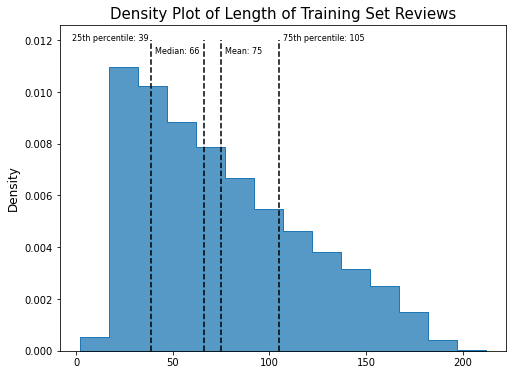

In [ ]:
# Before we pad the sequences, we first need to know the distribution of the length of these sequences

dist_lenseq = []
for seq in subtrain_sequences:
    dist_lenseq.append(len(seq))
perc = list(np.percentile(dist_lenseq, q = [25, 50, 75]))
perc.append(np.mean(dist_lenseq))

fig, ax = plt.subplots(figsize = (8, 6))
g = sns.histplot(dist_lenseq, stat = 'density', element = 'step', binwidth = 15)
ax.set_title('Density Plot of Length of Training Set Reviews', fontsize = 15)
ax.set_xlabel('')
ax.set_ylabel('Density', fontsize = 12)
ax.vlines(perc, 0, 0.012, colors = 'black', linestyles = 'dashed')
ax.annotate("25th percentile: {:0.0f}".format(perc[0]), (perc[0]-41,0.012), size = 8)
ax.annotate("Median: {:0.0f}".format(perc[1]), (perc[1]-25,0.0115), size = 8)
ax.annotate("Mean: {:0.0f}".format(perc[3]), (perc[3]+2,0.0115), size = 8)
ax.annotate("75th percentile: {:0.0f}".format(perc[2]), (perc[2]+2,0.012), size = 8);

Since the 75th percentile of the length of the tokenized training sequences is 105, I will truncate all tokenized sequences, from the end, to a length of 128. For tokenized sequences less than 128 tokens in length, I will pad the sequences at the end. This is applied to both the training and test sets of reviews. 

In [ ]:
max_length = 128
trunct_type = 'post'
pad_type = 'post'

In [ ]:
subtrain_padded = pad_sequences(subtrain_sequences, 
                                padding = pad_type, truncating = trunct_type, maxlen = max_length)

print(f"Checking to see that all padded training reviews have the same length as max_length above:")
assert np.max([len(padded) for padded in subtrain_padded])==max_length
print("Verified")

Checking to see that all padded training reviews have the same length as max_length above:
Verified


In [ ]:
# Now convert the test set into sequences and then pad them as well

subtest_sequences = tokenizer.texts_to_sequences(subtest_X)
subtest_padded = pad_sequences(subtest_sequences, 
                               padding = pad_type, truncating = trunct_type, maxlen = max_length)

print(f"Checking to see that all padded test reviews have the same length as max_length above:")
assert np.max([len(padded) for padded in subtest_padded])==max_length
print("Verified")


Checking to see that all padded test reviews have the same length as max_length above:
Verified


In [ ]:
subtrain_Y = [i-1 for i in subtrain_Y]
subtest_Y = [i-1 for i in subtest_Y]

In [ ]:
# Define an embedding dimension

embedding_dim = 100

In [ ]:
# Next, we define a callback function which will terminate the training when a certain value of accuracy is reached

accuracy_threshold = 0.96
global final_epoch 
final_epoch = 0
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > accuracy_threshold):
            print('Desired Accuracy Threshold Reached. Aborting Training. Epoch reached: {}'.format(epoch))
            global final_epoch
            final_epoch = epoch
            self.model.stop_training = True
callbacks = myCallBack()

### 3.a.1. Neural Network With Trainable Word Embeddings 

In [ ]:
num_units = 32

NN_model_a = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
NN_model_a.summary()
NN_model_a.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 100)          7172600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                409632    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,582,265
Trainable params: 7,582,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.random.set_seed(193)
num_epochs = 30
history_NN_model_a = NN_model_a.fit(subtrain_padded, np.array(subtrain_Y), 
                         validation_data = (subtest_padded, np.array(subtest_Y)), 
                         epochs = num_epochs, verbose = 2, callbacks = [callbacks])

Epoch 1/10
1125/1125 - 7s - loss: 0.4191 - accuracy: 0.7984 - val_loss: 0.3218 - val_accuracy: 0.8608
Epoch 2/10
1125/1125 - 5s - loss: 0.1043 - accuracy: 0.9630 - val_loss: 0.4610 - val_accuracy: 0.8298
Desired Accuracy Threshold Reached. Aborting Training. Epoch reached: 1


In [ ]:
# Define a function which plots the training and test loss and accuracy 

def plot_training(history, titname):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (17, 6))
    ax1.plot(history.history['accuracy'], color='navy')
    ax1.plot(history.history['val_accuracy'], color='red')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Accuracy', 'val_Accuracy'])

    ax2.plot(history.history['loss'], color='navy')
    ax2.plot(history.history['val_loss'], color='red')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel('Loss')
    ax2.legend(['Loss', 'val_Loss'])

    plt.tight_layout()    
    plt.suptitle(titname, fontsize = 15, y = 1.1)
    plt.show()

In [ ]:
if(final_epoch>3):
    plot_training(history_NN_model_a, 'Basic Neural Network With Trainable Word Embeddings')

In [ ]:
## Now we predict labels and the probability of those labels in the test set
Ypredproba_NN_model_a = list(NN_model_a.predict(subtest_padded).squeeze())
Ypred_NN_model_a = np.array([i>=0.5 for i in Ypredproba_NN_model_a], dtype = 'int')

In [ ]:
print(f"Evaluation of Test Set Classification Using Neural Networks With Trainable Word Embeddings:")
NN_model_a_test_metrics = evaluate_classification(subtest_Y, Ypred_NN_model_a, Ypredproba_NN_model_a, True)

Evaluation of Test Set Classification Using Neural Networks With Trainable Word Embeddings:
Accuracy: 0.830
Precision: 0.821
Recall: 0.844
F1 Score: 0.832
ROC AUC Score: 0.909


### 3.a.2. Neural Network With Pre-Trained Word Embeddings

In [ ]:
pretrain_embedding_dim = embeddings_index[list(embeddings_index.keys())[0]].shape[0]
embeddings_matrix = np.zeros((vocab_size+1,pretrain_embedding_dim)) 

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embeddings_matrix[i] = embedding_vector

In [ ]:
num_units = 32

NN_model_b = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
NN_model_b.summary()
NN_model_b.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 100)          7172700   
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                409632    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 7,582,365
Trainable params: 409,665
Non-trainable params: 7,172,700
_________________________________________________________________


In [ ]:
tf.random.set_seed(193)
final_epoch = 0
num_epochs = 30
history_NN_model_b = NN_model_b.fit(subtrain_padded, np.array(subtrain_Y), 
                         validation_data = (subtest_padded, np.array(subtest_Y)), 
                         epochs = num_epochs, verbose = 2, callbacks = [callbacks])

Epoch 1/30
1125/1125 - 2s - loss: 0.0800 - accuracy: 0.9708 - val_loss: 1.5631 - val_accuracy: 0.6973
Desired Accuracy Threshold Reached. Aborting Training. Epoch reached: 0


In [ ]:
if(final_epoch>3):
    plot_training(history_NN_model_b, 'Basic Neural Network With Pre-Trained Word Embeddings')

In [ ]:
## Now we predict labels and the probability of those labels in the test set
Ypredproba_NN_model_b = list(NN_model_b.predict(subtest_padded).squeeze())
Ypred_NN_model_b = np.array([i>=0.5 for i in Ypredproba_NN_model_b], dtype = 'int')

In [ ]:
print(f"Evaluation of Test Set Classification Using Neural Networks With Pre-Trained Word Embeddings:")
NN_model_b_test_metrics = evaluate_classification(subtest_Y, Ypred_NN_model_b, Ypredproba_NN_model_b, True)

Evaluation of Test Set Classification Using Neural Networks With Pre-Trained Word Embeddings:
Accuracy: 0.697
Precision: 0.680
Recall: 0.745
F1 Score: 0.711
ROC AUC Score: 0.769


### 3.b.1. Single Layer Bidirectional RNN With GRU Units And Trainable Word Embeddings

In [ ]:
num_units = 32
num_RNN_units = 64

GRU_model_a = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_RNN_units)),
    tf.keras.layers.Dense(num_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
GRU_model_a.summary()
GRU_model_a.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 128, 100)          7172600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               63744     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 7,240,505
Trainable params: 7,240,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.random.set_seed(193)
final_epoch = 0
num_epochs = 30
history_GRU_model_a = GRU_model_a.fit(subtrain_padded, np.array(subtrain_Y), 
                         validation_data = (subtest_padded, np.array(subtest_Y)), 
                         epochs = num_epochs, verbose = 2, callbacks = [callbacks])

Epoch 1/30
1125/1125 - 20s - loss: 0.4135 - accuracy: 0.8061 - val_loss: 0.3146 - val_accuracy: 0.8677
Epoch 2/30
1125/1125 - 14s - loss: 0.2096 - accuracy: 0.9191 - val_loss: 0.2979 - val_accuracy: 0.8780
Epoch 3/30
1125/1125 - 14s - loss: 0.1069 - accuracy: 0.9629 - val_loss: 0.3795 - val_accuracy: 0.8717
Desired Accuracy Threshold Reached. Aborting Training. Epoch reached: 2


In [ ]:
if(final_epoch>3):
    plot_training(history_GRU_model_a, 'Bidirectional Gated Recurrent Neural Network With Trainable Word Embeddings')

In [ ]:
## Now we predict labels and the probability of those labels in the test set
Ypredproba_GRU_model_a = list(GRU_model_a.predict(subtest_padded).squeeze())
Ypred_GRU_model_a = np.array([i>=0.5 for i in Ypredproba_GRU_model_a], dtype = 'int')

In [ ]:
print(f"Evaluation of Test Set Classification Using Gated Recurrent Neural Networks With Trainable Word Embeddings:")
GRU_model_a_test_metrics = evaluate_classification(subtest_Y, Ypred_GRU_model_a, Ypredproba_GRU_model_a, True)

Evaluation of Test Set Classification Using Gated Recurrent Neural Networks With Trainable Word Embeddings:
Accuracy: 0.872
Precision: 0.866
Recall: 0.879
F1 Score: 0.873
ROC AUC Score: 0.939


### 3.b.2. Single Layer Bidirectional RNN With GRU Units And Pre-Trained Word Embeddings 


In [ ]:
num_units = 32
num_RNN_units = 64

GRU_model_b = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_RNN_units)),
    tf.keras.layers.Dense(num_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
GRU_model_b.summary()
GRU_model_b.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 100)          7172700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               63744     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 7,240,605
Trainable params: 67,905
Non-trainable params: 7,172,700
_________________________________________________________________


In [ ]:
tf.random.set_seed(193)
final_epoch = 0
num_epochs = 30
history_GRU_model_b = GRU_model_b.fit(subtrain_padded, np.array(subtrain_Y), 
                         validation_data = (subtest_padded, np.array(subtest_Y)), 
                         epochs = num_epochs, verbose = 2, callbacks = [callbacks])

Epoch 1/30
1125/1125 - 14s - loss: 0.4908 - accuracy: 0.7568 - val_loss: 0.4015 - val_accuracy: 0.8190
Epoch 2/30
1125/1125 - 11s - loss: 0.3698 - accuracy: 0.8356 - val_loss: 0.3391 - val_accuracy: 0.8560
Epoch 3/30
1125/1125 - 11s - loss: 0.3201 - accuracy: 0.8621 - val_loss: 0.3066 - val_accuracy: 0.8695
Epoch 4/30
1125/1125 - 11s - loss: 0.2873 - accuracy: 0.8779 - val_loss: 0.2941 - val_accuracy: 0.8755
Epoch 5/30
1125/1125 - 11s - loss: 0.2568 - accuracy: 0.8941 - val_loss: 0.3044 - val_accuracy: 0.8735
Epoch 6/30
1125/1125 - 11s - loss: 0.2294 - accuracy: 0.9070 - val_loss: 0.3120 - val_accuracy: 0.8820
Epoch 7/30
1125/1125 - 11s - loss: 0.2002 - accuracy: 0.9204 - val_loss: 0.3149 - val_accuracy: 0.8750
Epoch 8/30
1125/1125 - 11s - loss: 0.1750 - accuracy: 0.9329 - val_loss: 0.3188 - val_accuracy: 0.8767
Epoch 9/30
1125/1125 - 11s - loss: 0.1487 - accuracy: 0.9436 - val_loss: 0.3625 - val_accuracy: 0.8777
Epoch 10/30
1125/1125 - 11s - loss: 0.1277 - accuracy: 0.9519 - val_loss:

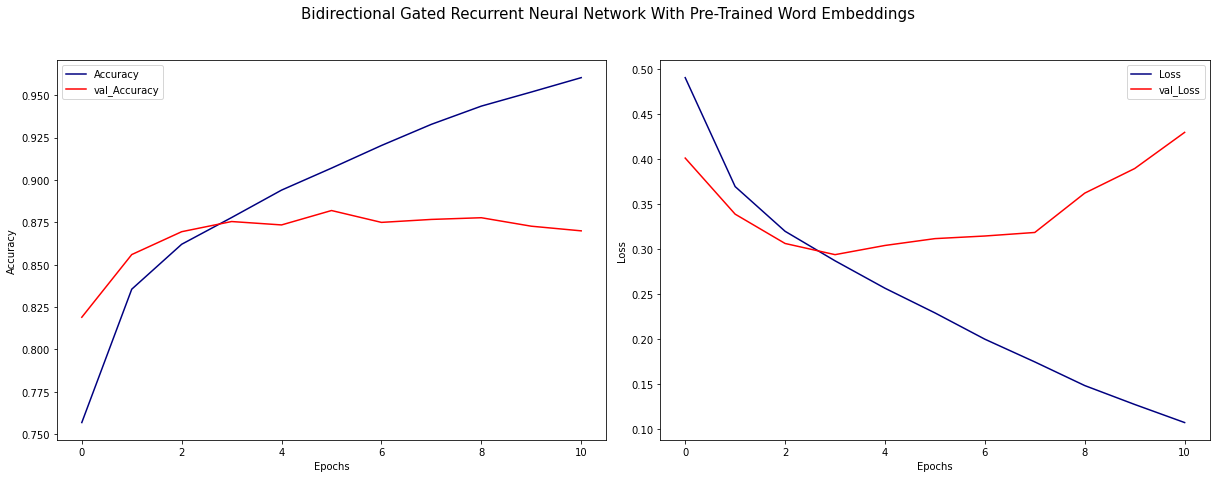

In [ ]:
if(final_epoch>3):
  plot_training(history_GRU_model_b, 'Bidirectional Gated Recurrent Neural Network With Pre-Trained Word Embeddings')

In [ ]:
## Now we predict labels and the probability of those labels in the test set
Ypredproba_GRU_model_b = list(GRU_model_b.predict(subtest_padded).squeeze())
Ypred_GRU_model_b = np.array([i>=0.5 for i in Ypredproba_GRU_model_b], dtype = 'int')

In [ ]:
print(f"Evaluation of Test Set Classification Using Gated Recurrent Neural Networks With Pre-Trained Word Embeddings:")
GRU_model_b_test_metrics = evaluate_classification(subtest_Y, Ypred_GRU_model_b, Ypredproba_GRU_model_b, True)

Evaluation of Test Set Classification Using Gated Recurrent Neural Networks With Pre-Trained Word Embeddings:
Accuracy: 0.870
Precision: 0.894
Recall: 0.840
F1 Score: 0.866
ROC AUC Score: 0.937


### 3.c.1. Single Layer RNN With LSTM Units And Trainable Word Embeddings

In [ ]:
num_units = 32
num_RNN_units = 64

LSTM_model_a = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_RNN_units)),
    tf.keras.layers.Dense(num_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
LSTM_model_a.summary()
LSTM_model_a.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 128, 100)          7172600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 7,261,241
Trainable params: 7,261,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.random.set_seed(193)
final_epoch = 0
num_epochs = 30
history_LSTM_model_a = LSTM_model_a.fit(subtrain_padded, np.array(subtrain_Y), 
                         validation_data = (subtest_padded, np.array(subtest_Y)), 
                         epochs = num_epochs, verbose = 2, callbacks = [callbacks])

Epoch 1/30
1125/1125 - 18s - loss: 0.4137 - accuracy: 0.8102 - val_loss: 0.3301 - val_accuracy: 0.8637
Epoch 2/30
1125/1125 - 16s - loss: 0.2207 - accuracy: 0.9162 - val_loss: 0.3270 - val_accuracy: 0.8630
Epoch 3/30
1125/1125 - 15s - loss: 0.1294 - accuracy: 0.9542 - val_loss: 0.4198 - val_accuracy: 0.8618
Epoch 4/30
1125/1125 - 15s - loss: 0.0835 - accuracy: 0.9721 - val_loss: 0.4932 - val_accuracy: 0.8610
Desired Accuracy Threshold Reached. Aborting Training. Epoch reached: 3


In [ ]:
if(final_epoch>3):
    plot_training(history_LSTM_model_a, 'Bidirectional LSTM Recurrent Neural Network With Trainable Word Embeddings')

In [ ]:
## Now we predict labels and the probability of those labels in the test set
Ypredproba_LSTM_model_a = list(LSTM_model_a.predict(subtest_padded).squeeze())
Ypred_LSTM_model_a = np.array([i>=0.5 for i in Ypredproba_LSTM_model_a], dtype = 'int')

In [ ]:
print(f"Evaluation of Test Set Classification Using LSTM Recurrent Neural Networks With Trainable Word Embeddings:")
LSTM_model_a_test_metrics = evaluate_classification(subtest_Y, Ypred_LSTM_model_a, Ypredproba_LSTM_model_a, True)

Evaluation of Test Set Classification Using LSTM Recurrent Neural Networks With Trainable Word Embeddings:
Accuracy: 0.861
Precision: 0.850
Recall: 0.877
F1 Score: 0.863
ROC AUC Score: 0.925


### 3.c.2. Single Layer Bidirectional RNN With LSTM Units And Pre-Trained Word Embeddings

In [ ]:
num_units = 32
num_RNN_units = 64

LSTM_model_b = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_RNN_units)),
    tf.keras.layers.Dense(num_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
LSTM_model_b.summary()
LSTM_model_b.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 128, 100)          7172700   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 7,261,341
Trainable params: 88,641
Non-trainable params: 7,172,700
_________________________________________________________________


In [ ]:
tf.random.set_seed(193)
final_epoch = 0
num_epochs = 30
history_LSTM_model_b = LSTM_model_b.fit(subtrain_padded, np.array(subtrain_Y), 
                         validation_data = (subtest_padded, np.array(subtest_Y)), 
                         epochs = num_epochs, verbose = 2, callbacks = [callbacks])

Epoch 1/30
1125/1125 - 16s - loss: 0.5255 - accuracy: 0.7367 - val_loss: 0.4206 - val_accuracy: 0.8067
Epoch 2/30
1125/1125 - 12s - loss: 0.3985 - accuracy: 0.8201 - val_loss: 0.3563 - val_accuracy: 0.8472
Epoch 3/30
1125/1125 - 12s - loss: 0.3455 - accuracy: 0.8485 - val_loss: 0.3194 - val_accuracy: 0.8627
Epoch 4/30
1125/1125 - 12s - loss: 0.3097 - accuracy: 0.8675 - val_loss: 0.3053 - val_accuracy: 0.8658
Epoch 5/30
1125/1125 - 12s - loss: 0.2776 - accuracy: 0.8843 - val_loss: 0.3247 - val_accuracy: 0.8565
Epoch 6/30
1125/1125 - 12s - loss: 0.2538 - accuracy: 0.8955 - val_loss: 0.3049 - val_accuracy: 0.8780
Epoch 7/30
1125/1125 - 12s - loss: 0.2263 - accuracy: 0.9081 - val_loss: 0.3098 - val_accuracy: 0.8700
Epoch 8/30
1125/1125 - 12s - loss: 0.2003 - accuracy: 0.9204 - val_loss: 0.3046 - val_accuracy: 0.8715
Epoch 9/30
1125/1125 - 12s - loss: 0.1755 - accuracy: 0.9315 - val_loss: 0.3279 - val_accuracy: 0.8733
Epoch 10/30
1125/1125 - 12s - loss: 0.1523 - accuracy: 0.9414 - val_loss:

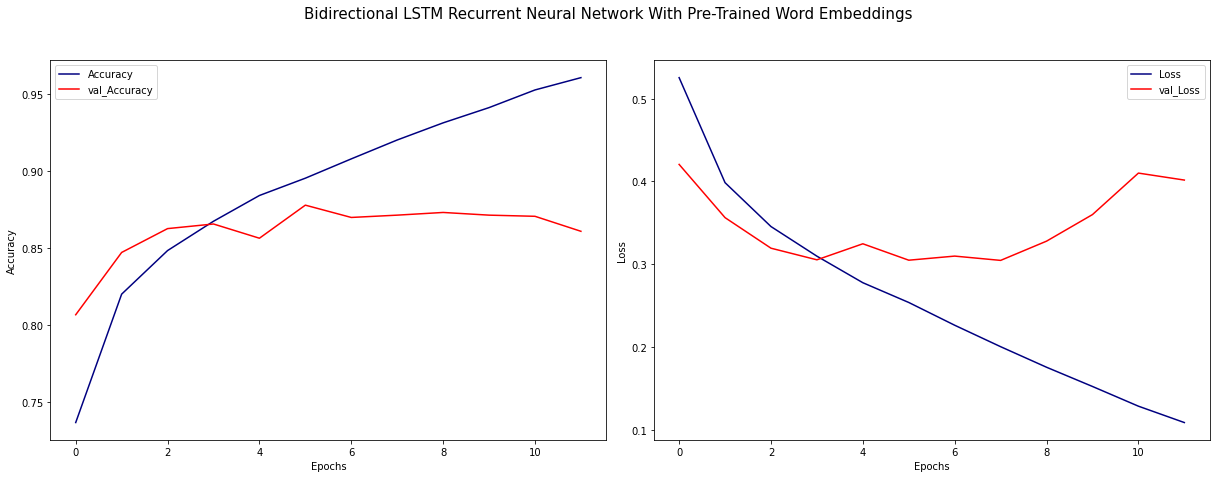

In [ ]:
if(final_epoch>3):
    plot_training(history_LSTM_model_b, 'Bidirectional LSTM Recurrent Neural Network With Pre-Trained Word Embeddings')

In [ ]:
## Now we predict labels and the probability of those labels in the test set
Ypredproba_LSTM_model_b = list(LSTM_model_b.predict(subtest_padded).squeeze())
Ypred_LSTM_model_b = np.array([i>=0.5 for i in Ypredproba_LSTM_model_b], dtype = 'int')

In [ ]:
print(f"Evaluation of Test Set Classification Using LSTM Recurrent Neural Networks With Pre-Trained Word Embeddings:")
LSTM_model_b_test_metrics = evaluate_classification(subtest_Y, Ypred_LSTM_model_b, Ypredproba_LSTM_model_b, True)

Evaluation of Test Set Classification Using LSTM Recurrent Neural Networks With Pre-Trained Word Embeddings:
Accuracy: 0.861
Precision: 0.845
Recall: 0.883
F1 Score: 0.864
ROC AUC Score: 0.937


In [ ]:
# Now generate lists of different metrics and models 

listmodel = ['Naive Bayes',
             'Neural Network - Trainable Embeddings','Neural Network - Pre-Trained Embeddings',
             'GRU - Trainable Embeddings','GRU - Pre-Trained Embeddings',
             'LSTM - Trainable Embeddings','LSTM - Pre-Trained Embeddings']
listaccuracy = [NB_test_metrics[0],
                NN_model_a_test_metrics[0], NN_model_b_test_metrics[0],
                GRU_model_a_test_metrics[0], GRU_model_b_test_metrics[0], 
                LSTM_model_a_test_metrics[0], LSTM_model_b_test_metrics[0]]
listprecision = [NB_test_metrics[1],
                NN_model_a_test_metrics[1], NN_model_b_test_metrics[1],
                GRU_model_a_test_metrics[1], GRU_model_b_test_metrics[1], 
                LSTM_model_a_test_metrics[1], LSTM_model_b_test_metrics[1]]
listrecall = [NB_test_metrics[2],
                NN_model_a_test_metrics[2], NN_model_b_test_metrics[2],
                GRU_model_a_test_metrics[2], GRU_model_b_test_metrics[2], 
                LSTM_model_a_test_metrics[2], LSTM_model_b_test_metrics[2]]
listf1 = [NB_test_metrics[3],
                NN_model_a_test_metrics[3], NN_model_b_test_metrics[3],
                GRU_model_a_test_metrics[3], GRU_model_b_test_metrics[3], 
                LSTM_model_a_test_metrics[3], LSTM_model_b_test_metrics[3]]
listrocauc = [np.nan,
                NN_model_a_test_metrics[4], NN_model_b_test_metrics[4],
                GRU_model_a_test_metrics[4], GRU_model_b_test_metrics[4], 
                LSTM_model_a_test_metrics[4], LSTM_model_b_test_metrics[4]]                

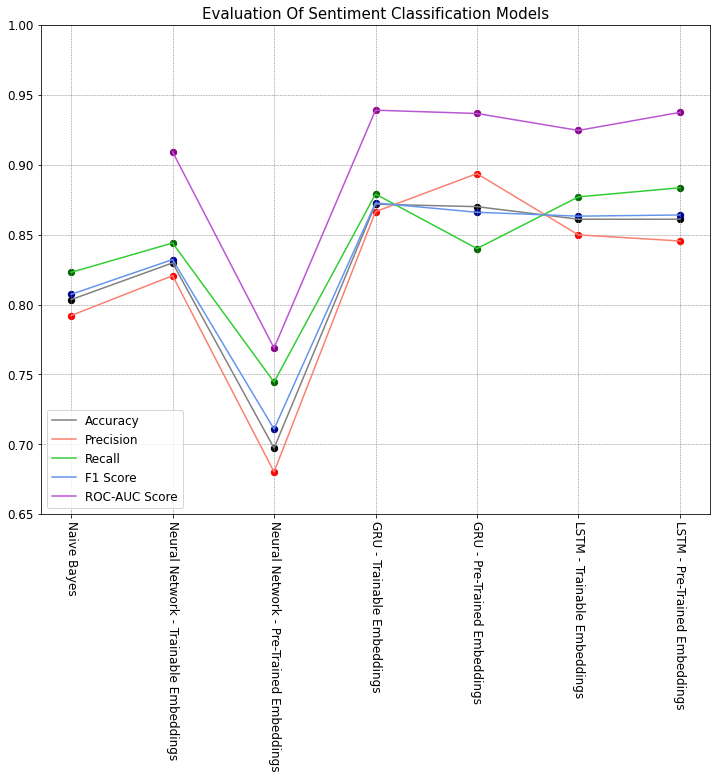

In [ ]:
# Now plot the evaluation metrics

fig, ax = plt.subplots(figsize = (12, 9))
ax.scatter(listmodel, listaccuracy, marker = 'o', s = 40, color = 'black', label = '')
ax.plot(listmodel, listaccuracy, color = 'grey', label = 'Accuracy')
ax.scatter(listmodel, listprecision, marker = 'o', s = 40, color = 'red', label = '')
ax.plot(listmodel, listprecision, color = 'salmon', label = 'Precision')
ax.scatter(listmodel, listrecall, marker = 'o', s = 40, color = 'darkgreen', label = '')
ax.plot(listmodel, listrecall, color = 'limegreen', label = 'Recall')
ax.scatter(listmodel, listf1, marker = 'o', s = 40, color = 'darkblue', label = '')
ax.plot(listmodel, listf1, color = 'cornflowerblue', label = 'F1 Score')
ax.scatter(listmodel, listrocauc, marker = 'o', s = 40, color = 'darkmagenta', label = '')
ax.plot(listmodel, listrocauc, color = 'mediumorchid', label = 'ROC-AUC Score')
ax.set_ylim([0.65, 1.0])
ax.set_xticklabels(listmodel, rotation = 270, fontsize = 12)
ax.tick_params(labelsize = 12)
plt.grid(which = 'major', color = 'grey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(loc = 'lower left', frameon = True, fancybox = True, fontsize = 12)
ax.set_title('Evaluation Of Sentiment Classification Models', fontsize = 15);
plt.savefig(os.path.join("drive/MyDrive", 'PredictionMetricsComparison_ClassifierModels.png'), 
           bbox_inches = 'tight')